In [0]:
import gzip
import tarfile
from io import BytesIO, StringIO
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import requests


In [0]:
order_url = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz"
user_url = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz"
restaurant_url = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz"
ab_test_url = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz"

In [0]:
import requests
import gzip
import io
import pandas as pd
import tarfile
from tqdm import tqdm

def download_file(url):
    "Download"
    response = requests.get(url, stream=True)
    response.raise_for_status()

    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte

    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

    content = io.BytesIO()
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        content.write(data)
    progress_bar.close()

    content.seek(0)
    return content

def load_json(url):
    """Load JSON file"""
    content = download_file(url)
    with gzip.GzipFile(fileobj=content) as f:
        return pd.read_json(f)

def load_gzipped_csv(url):
    """Load CSV file"""
    content = download_file(url)
    with gzip.GzipFile(fileobj=content) as f:
        return pd.read_csv(f)

def load_tar_gz_csv(url):
    """Load CSV - tar.gz"""
    content = download_file(url)
    with tarfile.open(fileobj=content, mode="r:gz") as tar:
        csv_file = [m for m in tar.getmembers() if m.name.endswith('.csv')][0]
        with tar.extractfile(csv_file) as f:
            return pd.read_csv(f)

In [0]:
orders_df = load_json(order_url)

100%|██████████| 1.61G/1.61G [01:36<00:00, 16.7MiB/s]


---------------------------------------------------------------------------
PermissionError                           Traceback (most recent call last)
File <command-8549807156780826>, line 1
----> 1 download_to_dbfs(order_url, order_dbfs)

File <command-8549807156780823>, line 7, in download_to_dbfs(order_url, order_dbfs, retries, backoff_factor)
      5 def download_to_dbfs(order_url, order_dbfs, retries=3, backoff_factor=0.3):
      6     # Create the directory if it does not exist
----> 7     os.makedirs(os.path.dirname(order_dbfs), exist_ok=True)
      8     for attempt in range(retries):
      9         try:

File <frozen os>:215, in makedirs(name, mode, exist_ok)

File <frozen os>:225, in makedirs(name, mode, exist_ok)

PermissionError: [Errno 13] Permission denied: '/FileStore'

I'm having connection problems with the download. I'll try to download the data manually in my machine with the following commands and upload the data to Databricks. 
-     curl -O https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz
-     curl -O https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz
-     curl -O https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz
-     curl -O https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz

This should solve the connection issues. It's also possible to upload the file to a S3 bucket but this can only be done on Databricks Premium. 

_Note: I also tried to download data directly from the URL with Google Colab but the sessions was breaking due to RAM limit since the JSON file is too big._

In [0]:
order_path = "/Volumes/workspace/default/dev/order.json.gz"

order_df = spark.read.json(
    order_path,
    multiLine=True
)

order_df.show(5)
order_df.printSchema()

+-----------+--------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------+--------------------+-----------------+------------------+-----------------+--------------------+--------------------+---------------+------------------+---------------+
|        cpf|         customer_id|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|               items|         merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|    order_created_at|            order_id|order_scheduled|order_total_amount|origin_platform|
+-----------+--------------------+-------------+---------------------+------------------------+-------------------

Create tables from CSV files:
- restaraunt.csv.gz: This file was uploaded directly to DataBricks after unzip. 
- consumer.csv.gz: This file was having problem to unzip directly on mac so I used the command `gunzip consumer.csv.gz` in my terminal. After that, the file was uploaded directly to DataBricks. 

In [0]:
restaurant_df = spark.table("workspace.default.restaurant")
restaurant_df.show(5)

+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|                  id|          created_at|enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code| merchant_city|merchant_state|merchant_country|
+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|d19ff6fca6288939b...|2017-01-23 12:52:...|  false|          3|          60.0|           0|           50|               30.0|            14025|RIBEIRAO PRETO|            SP|              BR|
|631df0985fdbbaf27...|2017-01-20 13:14:...|   true|          3|          60.0|           0|            0|               30.0|            50180|     SAO PAULO|            SP|              BR|
|135c5c4ae4c1ec1fd...|2017-01-23 12:46:...|  

In [0]:
user_df = spark.table("workspace.default.consumer")
user_df.show(5)

+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|         customer_id|language|          created_at|active|customer_name|customer_phone_area|customer_phone_number|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|e8cc60860e09c0bb1...|   pt-br|2018-04-05 14:49:...|  true|         NUNO|                 46|            816135924|
|a2834a38a9876cf74...|   pt-br|2018-01-14 21:40:...|  true|     ADRIELLY|                 59|            231330577|
|41e1051728eba1334...|   pt-br|2018-01-07 03:47:...|  true|        PAULA|                 62|            347597883|
|8e7c1dcb64edf95c9...|   pt-br|2018-01-10 22:17:...|  true|       HELTON|                 13|            719366842|
|7823d4cf4150c5dae...|   pt-br|2018-04-06 00:16:...|  true|       WENDER|                 76|            543232158|
+--------------------+--------+--------------------+------+-------------

In [0]:
# Extract files from ab_test_ref.tar.gz
tar_file = "/Volumes/workspace/default/dev/ab_test_ref.tar.gz"
extract_dir = "/Volumes/workspace/default/dev/ab_test_ref_extracted/"

os.makedirs(extract_dir, exist_ok=True)

with tarfile.open(tar_file, "r:gz") as tar:
    tar.extractall(path=extract_dir)

print(f"Extracted to: {extract_dir}")


Extracted to: /Volumes/workspace/default/dev/ab_test_ref_extracted/


In [0]:
ab_test_path = "/Volumes/workspace/default/dev/ab_test_ref_extracted/ab_test_ref.csv"
ab_test_ref_path = "/Volumes/workspace/default/dev/ab_test_ref_extracted/._ab_test_ref.csv"

ab_test_df = spark.read.csv(
    ab_test_path,
    header=True,
    inferSchema=True
)

ab_test_df.show(5)

+--------------------+---------+
|         customer_id|is_target|
+--------------------+---------+
|755e1fa18f25caec5...|   target|
|b821aa8372b8e5b82...|  control|
|d425d6ee4c9d4e211...|  control|
|6a7089eea0a5dc294...|   target|
|dad6b7e222bab31c0...|  control|
+--------------------+---------+
only showing top 5 rows


In [0]:
ab_test_ref_df = spark.read.csv(
    ab_test_ref_path,
    header=True,
    inferSchema=True
)

ab_test_ref_df.show(5)

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-8549807156780857>, line 7
      1 ab_test_ref_df = spark.read.csv(
      2     ab_test_ref_path,
      3     header=True,
      4     inferSchema=True
      5 )
----> 7 ab_test_ref_df.show(5)

File /databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/dataframe.py:1193, in DataFrame.show(self, n, truncate, vertical)
   1192 def show(self, n: int = 20, truncate: Union[bool, int] = True, vertical: bool = False) -> None:
-> 1193     print(self._show_string(n, truncate, vertical))

File /databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/dataframe.py:934, in DataFrame._show_string(self, n, truncate, vertical)
    917     except ValueError:
    918         raise PySparkTypeError(
    919             error_class="NOT_BOOL",
    920             message_parameters={
   (...)
    923             },
   

In [0]:
dbutils.fs.head(ab_test_ref_path, 1000)

'\x00\x05\x16\x07\x00\x02\x00\x00Mac OS X        \x00\x02\x00\x00\x00\t\x00\x00\x002\x00\x00\x00~\x00\x00\x00\x02\x00\x00\x00�\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ATTR\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00�\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00�\x00\x00\x00\x18\x00\x00\x15com.apple.quarantine\x00q/0081;679aae17;Chrome;\x00'

File `._ab_test_ref.csv` seems to be corrupted. I'll follow with the case anyway since it probably won't be used. 

In [0]:
print(f"Order DataFrame Rows: {order_df.count()}")
print(f"User DataFrame Rows: {user_df.count()}")
print(f"Restaurant DataFrame Rows: {restaurant_df.count()}")
print(f"AB Test DataFrame Rows: {ab_test_df.count()}")

Order DataFrame Rows: 3670826
User DataFrame Rows: 806156
Restaurant DataFrame Rows: 7292
AB Test DataFrame Rows: 806467


## Questão 01
### Indicadores Relevantes
- Taxa de retençao do usuário (Retention Rate - RR): Porcentagem de usuários que fizeram mais de um pedido 7 dias e 30 dias após o inicio da campanha. 
- Frequencia de pedidos durante/após a campanha.
- Valor Médio do Pedido (Average Order Value - AOV).
- Taxa de conversão (Conversion Rate - CR): Taxa de usuários que utilizaram o cupom. 
- Receita por Usuário (Revenue per User - RPU): Valor total dos pedidos dividido pela quantidade de usuários no grupo. 
- Usuários Ativos (Active Users): Quantidade de dias que o usuário fez um pedido. 
- Retorno Sobre Investimento (Return Over Investment - ROI): Receita Incremental / Gasto Total

In [0]:
from pyspark.sql.functions import col, countDistinct, count, avg, sum, when, to_date, to_timestamp, min, max
from pyspark.sql.types import StructType, StructField, StringType, BooleanType, DoubleType

In [0]:
## Data Cleaning

order_df_clean = (order_df
            .withColumn("order_created_at", to_timestamp("order_created_at"))
            .dropDuplicates(["order_id"]))

user_df_clean = (user_df
            .withColumn("created_at", to_timestamp("created_at"))
            .dropDuplicates(["customer_id"])
            .withColumnRenamed("customer_id", "user_id"))

ab_test_df_clean = ab_test_df.withColumnRenamed("customer_id", "user_id")

In [0]:
test_group_df = user_df_clean.join(
        ab_test_df_clean.withColumn("group", 
                             when(col("is_target") == "target", "treatment")
                             .otherwise("control")),
        "user_id", 
        "left"
    )

df_analysis = order_df_clean.join(
        test_group_df, 
        order_df.customer_id == test_group_df.user_id, 
        "inner"
    )

In [0]:
import pyspark.sql.functions as F

## Retention Rate

def calculate_retention_rate(df, start_date, window):
    end_date = start_date + pd.DateOffset(days=window)
    
    total_users = df.groupBy("group").agg(
        countDistinct("user_id").alias("total_users")
    )
    
    retained_users = df.filter(
        (col("order_created_at") >= start_date) & 
        (col("order_created_at") <= end_date)
    ).groupBy("group", "user_id").agg(
        F.count("order_id").alias("order_count")
    ).filter(
        col("order_count") > 1  
    ).groupBy("group").agg(
        F.countDistinct("user_id").alias("retained_users")
    )
    
    retention_rate = total_users.join(
        retained_users, "group", "left"
    ).withColumn(
        "retention_rate", 
        F.coalesce(col("retained_users"), F.lit(0)) / col("total_users")
    )
    
## Calculate statistical significance:
## I chose to use the z-test instead of the chi-squared test because we are comparing proportions between only two groups. In this context, the z-test is more straightforward and interpretable. The chi-squared test is more appropriate for analyzing associations across multiple categories or larger contingency tables.

    control = retention_rate.filter(col("group") == "control").collect()[0]
    treatment = retention_rate.filter(col("group") == "treatment").collect()[0]
    
    n_control = control["total_users"]
    p_control = control["retention_rate"]
    n_treatment = treatment["total_users"]
    p_treatment = treatment["retention_rate"]
    
    pooled_p = (p_control * n_control + p_treatment * n_treatment) / (n_control + n_treatment)
    se = np.sqrt(pooled_p * (1 - pooled_p) * (1/n_control + 1/n_treatment))
    z = (p_treatment - p_control) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return retention_rate, (z, p_value)

In [0]:
df_analysis.select(F.max("order_created_at")).collect()[0][0]

datetime.datetime(2019, 1, 31, 23, 59, 59)

In [0]:
df_analysis.select(F.min("order_created_at")).collect()[0][0]

datetime.datetime(2019, 1, 1, 0, 0)

In [0]:
## Retention Rate - 7 days.

window = 7
start_date = df_analysis.select(F.min("order_created_at")).collect()[0][0]

rr_df, rr_test = calculate_retention_rate(df_analysis, start_date, window)

print("\nRetention Rate - 7d:")
rr_df.show()
print(f"Statistical Significance (Z-score, p-value): {rr_test}")


Retention Rate - 7d:
+---------+-----------+--------------+-------------------+
|    group|total_users|retained_users|     retention_rate|
+---------+-----------+--------------+-------------------+
|  control|     360413|         36538|0.10137814118802596|
|treatment|     445743|         54888|0.12313822090307644|
+---------+-----------+--------------+-------------------+

Statistical Significance (Z-score, p-value): (30.634207628393426, 0.0)


In [0]:
## Retention Rate - One month.
## Retention Rate can also be calculated for different periods of time. It's common to make calculations of RR for 7 days, 14 days, 30 days and even one year after the campaing. For this case, we'll only use 7d and 31d since we only have one month of data. 

window = 31
start_date = df_analysis.select(F.min("order_created_at")).collect()[0][0]

rr_df, rr_test = calculate_retention_rate(df_analysis, start_date, window)

print("\nRetention Rate - One Month:")
rr_df.show()
print(f"Statistical Significance (Z-score, p-value): {rr_test}")


Retention Rate - One Year:
+---------+-----------+--------------+------------------+
|    group|total_users|retained_users|    retention_rate|
+---------+-----------+--------------+------------------+
|  control|     360413|        171650|0.4762591804402172|
|treatment|     445743|        256819| 0.576159356400437|
+---------+-----------+--------------+------------------+

Statistical Significance (Z-score, p-value): (89.37016645137007, 0.0)


In [0]:
## Frequency

from pyspark.sql.functions import pandas_udf

def calculate_frequency(df, start_date, window):
    end_date = start_date + pd.DateOffset(days=window)
    
    order_count = df.filter(
        (col("order_created_at") >= start_date) & 
        (col("order_created_at") <= end_date)
    ).groupBy("group", "user_id").agg(
        F.count("order_id").alias("order_count")
    )

    frequency_df = order_count.groupBy("group").agg(
        F.avg("order_count").alias("avg_order_frequency")
    )
    
    ## Calculate statistical significance:
    ## I chose to use the T-test instead of the z-test test due to unknown variance. z-test is usually applied to proportions (like retention and conversion) while the T-test is usually applied to compare averages (like frequency and AOV) with unknown variance.  

    @pandas_udf("double")
    def collect_order_counts(iterator):
        for batch in iterator:
            yield batch
            
    control_data = order_count.filter(col("group") == "control").select("order_count").toPandas()["order_count"].values
    treatment_data = order_count.filter(col("group") == "treatment").select("order_count").toPandas()["order_count"].values
    
    t_stat, p_value = stats.ttest_ind(treatment_data, control_data, equal_var=False)
    
    return frequency_df, (t_stat, p_value)

In [0]:
## Frequency
## Frequency can also be calculated for multiple periods but for the purpose of this case, we'll use the entire month. 

window = 31
start_date = df_analysis.select(F.min("order_created_at")).collect()[0][0]

frequency_df, freq_test = calculate_frequency(df_analysis, start_date, window)

print("\nOrder Frequency per User:")
frequency_df.show()
print(f"Statistical Significance (T-stat, p-value): {freq_test}")


Order Frequency per User:
+---------+-------------------+
|    group|avg_order_frequency|
+---------+-------------------+
|  control|  2.803428289212653|
|treatment|  3.177162625100114|
+---------+-------------------+

Statistical Significance (T-stat, p-value): (44.91157803119559, 0.0)


In [0]:
## Average Order Value

def calculate_AOV(df, start_date, window):
   end_date = start_date + pd.DateOffset(days=window)
    
   aov_df = df.filter(
        (col("order_created_at") >= start_date) & 
        (col("order_created_at") <= end_date)
    ).groupBy("group").agg(
        F.avg("order_total_amount").alias("average_order_value")
    )
    
    ## Calculate statistical significance:
   control_data = df.filter(
        (col("order_created_at") >= start_date) & 
        (col("order_created_at") <= end_date) &
        (col("group") == "control")
    ).select("order_total_amount").toPandas()["order_total_amount"].values
    
   treatment_data = df.filter(
        (col("order_created_at") >= start_date) & 
        (col("order_created_at") <= end_date) &
        (col("group") == "treatment")
    ).select("order_total_amount").toPandas()["order_total_amount"].values
    
   t_stat, p_value = stats.ttest_ind(treatment_data, control_data, equal_var=False)
    
   return aov_df, (t_stat, p_value)

In [0]:
## Average Order Value

window = 31
start_date = df_analysis.select(F.min("order_created_at")).collect()[0][0]

aov_df, aov_test = calculate_AOV(df_analysis, start_date, window)

print("\nAverage Order Value:")
aov_df.show()
print(f"Statistical Significance (T-stat, p-value): {aov_test}")


Average Order Value:
+---------+-------------------+
|    group|average_order_value|
+---------+-------------------+
|  control| 47.917294188798955|
|treatment| 47.809652936971844|
+---------+-------------------+

Statistical Significance (T-stat, p-value): (-0.7124898986957318, 0.47616160619705794)


In [0]:
restaurant_df = spark.table("workspace.default.restaurant")

In [0]:
## Conversion Rate
## There's no field to indicate if the discount was applied or not. To calculate conversion rate, we'll assume that orders below the average ticket of the restaurant used the discount. We'll assume a 15% discount for calculation purposes. This metric may not be relevant due to this assumptions. 

def calculate_conversion_rate(df, start_date, window):
    end_date = start_date + pd.DateOffset(days=window)
    
    total_users = df.groupBy("group").agg(
        F.countDistinct("user_id").alias("total_users")
    )
    
    # Orders with avg ticket smaller than avg ticket of the restaurant:
    converted_users = df.filter(
        (col("order_created_at") >= start_date) & 
        (col("order_created_at") <= end_date)
    ).join(
        restaurant_df.select("id", "average_ticket"),
        df.merchant_id == restaurant_df.id,
        "left"
    ).filter(
        col("order_total_amount") < col("average_ticket") * 0.85 
    ).groupBy("group").agg(
        F.countDistinct("user_id").alias("converted_users")
    )
    
    conversion_rate = total_users.join(
        converted_users, "group", "left"
    ).withColumn(
        "conversion_rate", 
        F.coalesce(col("converted_users"), F.lit(0)) / col("total_users")
    )
    
    # Calculate statistical significance:
    control = conversion_rate.filter(col("group") == "control").collect()[0]
    treatment = conversion_rate.filter(col("group") == "treatment").collect()[0]
    
    n_control = control["total_users"]
    p_control = control["conversion_rate"]
    n_treatment = treatment["total_users"]
    p_treatment = treatment["conversion_rate"]
    
    pooled_p = (p_control * n_control + p_treatment * n_treatment) / (n_control + n_treatment)
    se = np.sqrt(pooled_p * (1 - pooled_p) * (1/n_control + 1/n_treatment))
    z = (p_treatment - p_control) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return conversion_rate, (z, p_value)


In [0]:
## Conversion Rate

window = 31
start_date = df_analysis.select(F.min("order_created_at")).collect()[0][0]

cr_df, cr_test = calculate_conversion_rate(df_analysis, start_date, window)

print("\nConversion Rate (assuming 15% discount):")
cr_df.show()
print(f"Statistical Significance (z-test, p-value): {cr_test}")


Conversion Rate (assuming 15% discount):
+---------+-----------+---------------+------------------+
|    group|total_users|converted_users|   conversion_rate|
+---------+-----------+---------------+------------------+
|  control|     360413|         265735|0.7373069228912387|
|treatment|     445743|         339953|0.7626659308166365|
+---------+-----------+---------------+------------------+

Statistical Significance (z-test, p-value): (44.91157803119559, 0.0)


In [0]:
## Revenue per User

def revenue_per_user(df, start_date, window):
    end_date = start_date + pd.DateOffset(days=window)
    
    revenue = df.filter(
        (col("order_created_at") >= start_date) & 
        (col("order_created_at") <= end_date)
    ).groupBy("group", "user_id").agg(
        F.sum("order_total_amount").alias("user_revenue")
    )
    
    revenue_per_user_df = revenue.groupBy("group").agg(
        F.sum("user_revenue").alias("total_revenue"),
        F.countDistinct("user_id").alias("total_users")
    ).withColumn(
        "revenue_per_user", 
        col("total_revenue") / col("total_users")
    )
    
    # Calculate statistical significance:
    control_data = revenue.filter(col("group") == "control").select("user_revenue").toPandas()["user_revenue"].values
    treatment_data = revenue.filter(col("group") == "treatment").select("user_revenue").toPandas()["user_revenue"].values
    
    t_stat, p_value = stats.ttest_ind(treatment_data, control_data, equal_var=False)
    
    return revenue_per_user_df, (t_stat, p_value)


In [0]:
## Revenue Per User

window = 31
start_date = df_analysis.select(F.min("order_created_at")).collect()[0][0]

revenue_per_user_df, rpu_test = revenue_per_user(df_analysis, start_date, window)

print("\nRevenue Per User:")
revenue_per_user_df.show()
print(f"Statistical Significance (T-stat, p-value): {rpu_test}")


Revenue Per User:
+---------+-------------------+-----------+------------------+
|    group|      total_revenue|total_users|  revenue_per_user|
+---------+-------------------+-----------+------------------+
|  control|4.841525070999869E7|     360413|134.33269807137557|
|treatment| 6.77079348699974E7|     445743|151.89904243027348|
+---------+-------------------+-----------+------------------+

Statistical Significance (T-stat, p-value): (27.922288461637052, 1.8152464522660235e-171)


In [0]:
## Active Users

def calculate_active_users(df, start_date, window_days):
    end_date = start_date + pd.DateOffset(days=window_days)
    
    active_days = df.filter(
        (col("order_created_at") >= start_date) & 
        (col("order_created_at") <= end_date)
    ).groupBy("group", "user_id").agg(
        F.countDistinct(F.to_date("order_created_at")).alias("active_days")
    )
    
    active_df = active_days.groupBy("group").agg(
        F.avg("active_days").alias("avg_active_days")
    )
    
    # Calculate statistical significance:
    control_data = active_days.filter(col("group") == "control").select("active_days").toPandas()["active_days"].values
    treatment_data = active_days.filter(col("group") == "treatment").select("active_days").toPandas()["active_days"].values
    
    t_stat, p_value = stats.ttest_ind(treatment_data, control_data, equal_var=False)
    
    return active_df, (t_stat, p_value)

In [0]:
## Active Users

window = 31
start_date = df_analysis.select(F.min("order_created_at")).collect()[0][0]

active_users_df, au_test = calculate_active_users(df_analysis, start_date, window)

print("\nActive Users:")
active_users_df.show()
print(f"Statistical Significance (T-stat, p-value): {au_test}")


Active Users:
+---------+------------------+
|    group|   avg_active_days|
+---------+------------------+
|  control|2.5459902944677357|
|treatment| 2.865548084882993|
+---------+------------------+

Statistical Significance (T-stat, p-value): (49.6740104264511, 0.0)


## Viabilidade Financeira
- Para estimar a viabilidade financeira da campanha (ROI), assumimos que o valor do cupom concedido foi de 15%. Inicialmente, avaliamos o AOV (valor médio do pedido) como base para estimar o custo do cupom. No entanto, observamos que o AOV do grupo tratamento foi praticamente igual ao do grupo controle, indicando que o desconto não reduziu o valor médio por pedido.

- Utilizamos o AOV médio do grupo controle como proxy para o valor base do pedido. Aplicamos o desconto de 15% sobre esse valor e multiplicamos pela quantidade de usuários do grupo tratamento, considerando apenas o primeiro pedido de cada usuário como elegível ao cupom.

- Adicionalmente, assumimos um take rate (percentual da receita retida pela plataforma) de 30% para estimar a margem gerada pela campanha. Essa abordagem permite uma estimativa mais conservadora e alinhada com a lógica financeira do negócio.

In [0]:
from pyspark.sql.window import Window

percentage = 0.15 
window_function = Window.partitionBy("user_id").orderBy("order_created_at")

first_orders = df_analysis.withColumn("order_rank", F.row_number().over(window_function))
first_orders_only = first_orders.filter(col("order_rank") == 1)

control_stats = df_analysis.filter(
        (col("group") == "control")
    ).agg(
        F.sum("order_total_amount").alias("control_total_revenue"),
        F.countDistinct("user_id").alias("control_total_users"),
        F.count("order_id").alias("control_total_orders")
    ).collect()[0]
    
treatment_stats = first_orders_only.filter(
        (col("group") == "treatment")
    ).agg(
        F.countDistinct("user_id").alias("treatment_total_users")
    ).collect()[0]
    
avg_order_amt = control_stats["control_total_revenue"] / control_stats["control_total_orders"]
total_cost = avg_order_amt * treatment_stats["treatment_total_users"] * percentage 

In [0]:
total_cost

3203819.769539246

In [0]:
from scipy.stats import ttest_ind

def calculate_roi(df, campaign_cost, take_rate):

    revenue_df = df.groupBy("group").agg(
        F.sum("order_total_amount").alias("total_revenue")
    )

    control_rev = revenue_df.filter(col("group") == "control").collect()[0]["total_revenue"]
    treatment_rev = revenue_df.filter(col("group") == "treatment").collect()[0]["total_revenue"]
    
    incremental_revenue = (treatment_rev - control_rev) * take_rate
    roi_df = (incremental_revenue - campaign_cost) / campaign_cost
    
    return roi_df

In [0]:
campaign_cost = total_cost
take_rate = 0.3
roi_df = calculate_roi(df_analysis, campaign_cost, take_rate)

print("\n7. Return Over Investment (ROI):")
print(roi_df)


7. Return Over Investment (ROI):
0.8065327216704472


In [0]:
revenue_df = df_analysis.groupBy("group").agg(
    F.sum("order_total_amount").alias("total_revenue")
)

control_rev = revenue_df.filter(col("group") == "control").collect()[0]["total_revenue"]
treatment_rev = revenue_df.filter(col("group") == "treatment").collect()[0]["total_revenue"]

incremental_revenue = (treatment_rev - control_rev) * take_rate
print(incremental_revenue)

5787805.248007319


## Questão 02
### Segmentaçao de Usuários:

1. Segmentação por Frequência de Pedidos (últimos 30 dias):
Classifica os usuários com base na intensidade de uso recente da plataforma.

- Inativos: Nenhum pedido realizado nos últimos 30 dias
- Baixa Frequência (Low Users): 1 a 3 pedidos no período
- Alta Frequência (High Users): 4 a 7 pedidos no período
- Intensivos (Ultra Users): 8 ou mais pedidos no período

Objetivo: Identificar padrões de engajamento e avaliar a resposta à campanha conforme o nível de atividade.

2. Segmentação por Ticket Médio:
Agrupa os usuários de acordo com o valor médio gasto por pedido.

- Baixo Valor: Ticket médio até R$ 20
- Médio Valor: Ticket médio entre R$ 20 e R$ 40
- Alto Valor: Ticket médio acima de R$ 40

Objetivo: Analisar se os cupons são mais eficazes para impulsionar o consumo entre usuários de menor poder aquisitivo ou entre heavy users.

3. Segmentação por Lifecycle:
Leva em consideração o tempo de relacionamento com a plataforma.

- Novos Usuários: Conta criada há menos de 14 dias antes ou durante o teste. 
- Usuários existentes: Todos os outros usuários.  

Objetivo: Avaliar o impacto da campanha em diferentes estágios do ciclo de vida do cliente.

Notas: 
- Inicialmente, buscamos identificar padrões de comportamento que justificassem o agrupamento de usuários em segmentos acionáveis. Embora a aplicação de técnicas mais sofisticadas, como clusterização por percentis ou modelagem baseada em lifetime value, fosse desejável, optamos por segmentações heurísticas baseadas em regras de negócio e facilidade de interpretação.
- Além disso, observamos uma limitação relevante: não havia novos usuários no recorte temporal analisado. Isso impossibilitou a avaliação do impacto da campanha em cadastros recentes, reduzindo a abrangência da segmentação por ciclo de vida e restringindo o foco apenas aos usuários existentes.
- Observamos também a ausência de dados anteriores ao início da campanha, o que pode introduzir vieses na análise, especialmente porque a segmentação dos usuários foi realizada com base em comportamentos registrados durante o próprio período da campanha.

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [0]:
user_df_new = (user_df.withColumnRenamed("customer_id", "user_id")
                        .withColumn("user_created_at", F.to_date("created_at"))
                        .drop("created_at"))

order_df_new = order_df.withColumnRenamed("customer_id", "user_id")

ab_test_df_new = ab_test_df.withColumnRenamed("customer_id", "user_id")

In [0]:
full_dataset_df = order_df_new.join(
        user_df_new, "user_id", "left"
    ).join(
        ab_test_df_new, "user_id", "left"
    ).withColumn(
        "group", 
        F.when(F.col("is_target") == "target", "treatment")
         .otherwise("control")
    )
full_df = full_dataset_df.withColumn(
        "order_created_at", 
        F.to_date("order_created_at")
    )

In [0]:
full_df.select(F.min("user_created_at")).collect()[0][0]

datetime.date(2018, 1, 2)

In [0]:
full_df.select(F.max("user_created_at")).collect()[0][0]

datetime.date(2018, 4, 6)

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, col, date_sub, date_add

def calculate_segments(df, campaign_start_date):
    """
    Create user segments based on frequency, ticket size, and lifecycle.
    """
    campaign_date_lit = F.to_date(F.lit(campaign_start_date))

    # Frequency Segmentation (during campaing - there's no data available before that but the ideal would be to calculate before)
    freq_df = df.filter(
        col("order_created_at") >= campaign_date_lit
    ).filter(
        col("order_created_at") <= date_add(campaign_date_lit, 30)
    ).groupBy("user_id").agg(
        F.count("order_id").alias("order_count")
    ).withColumn(
        "frequency_segment",
        F.when(F.col("order_count") == 0, "inactive")
         .when(F.col("order_count").between(1, 3), "low_frequency")
         .when(F.col("order_count").between(4, 7), "high_frequency")
         .otherwise("ultra_frequency")
    )

    # AOV Segmentation
    ticket_df = df.groupBy("user_id").agg(
        F.avg("order_total_amount").alias("avg_ticket")
    ).withColumn(
        "ticket_segment",
        F.when(F.col("avg_ticket") <= 20, "low_value")
         .when(F.col("avg_ticket").between(20, 40), "medium_value")
         .otherwise("high_value")
    )

    # Lifecycle Segmentation
    lifecycle_df = df.groupBy("user_id").agg(
        F.min("user_created_at").alias("signup_date")
    ).withColumn(
        "lifecycle_segment",
        F.when(
            F.col("signup_date") >= F.date_sub(campaign_date_lit, 14),
            "new_user"
        ).otherwise("existing_user")
    )

    # Final join
    return df.join(freq_df, "user_id", "left") \
             .join(ticket_df, "user_id", "left") \
             .join(lifecycle_df, "user_id", "left")


In [0]:
campaign_start_date = df_analysis.select(F.min("order_created_at")).collect()[0][0]

In [0]:
## Create segments
segmented_df = calculate_segments(full_df, campaign_start_date)

In [0]:
def calculate_retention(df, campaign_start_date, retention_days=7):
    """
    Calculate retention (users who made another order after X days)
    """
    window_spec = Window.partitionBy("user_id").orderBy("order_created_at")
    
    orders_with_sequence = df.withColumn(
        "order_rank", 
        F.row_number().over(window_spec)
    ).withColumn(
        "next_order_date",
        F.lead("order_created_at").over(window_spec)
    ).withColumn(
        "days_to_next_order",
        F.datediff("next_order_date", "order_created_at")
    )
    
    first_orders = orders_with_sequence.filter(
        (F.col("order_rank") == 1) &
        (F.col("order_created_at") >= campaign_start_date)
    ).select(
        "user_id",
        "order_created_at",
        "frequency_segment",
        "ticket_segment",
        "lifecycle_segment",
        "group"
    )

    retained_users = orders_with_sequence.filter(
        (F.col("order_rank") == 2) &
        (F.col("days_to_next_order") >= retention_days)
    ).select("user_id").distinct().withColumn(
        "is_retained", F.lit(True)
    )

    def retention_by_segment(segment_col):
        return first_orders.join(
            retained_users, "user_id", "left"
        ).groupBy("group", segment_col).agg(
            F.count("user_id").alias("total_users"),
            F.sum(F.when(F.col("is_retained"), 1).otherwise(0)).alias("retained_users")
        ).withColumn(
            "retention_rate",
            F.when(F.col("total_users") > 0, 
                  F.col("retained_users") / F.col("total_users"))
            .otherwise(F.lit(None))
        ).orderBy(segment_col, "group")
    
    return {
        "frequency_retention": retention_by_segment("frequency_segment"),
        "ticket_retention": retention_by_segment("ticket_segment"),
        "lifecycle_retention": retention_by_segment("lifecycle_segment")
    }

In [0]:
# Calculate retention
retention_results = calculate_retention(segmented_df, campaign_start_date)

In [0]:
retention_results["frequency_retention"].show()
retention_results["ticket_retention"].show()
retention_results["lifecycle_retention"].show()

+---------+-----------------+-----------+--------------+--------------------+
|    group|frequency_segment|total_users|retained_users|      retention_rate|
+---------+-----------------+-----------+--------------+--------------------+
|  control|   high_frequency|       3919|          1038|  0.2648634855830569|
|treatment|   high_frequency|       5809|          1573|  0.2707867102771561|
|  control|    low_frequency|     114745|          2521|0.021970456229029586|
|treatment|    low_frequency|     126622|          3789|0.029923709939820884|
|  control|  ultra_frequency|        332|            22| 0.06626506024096386|
|treatment|  ultra_frequency|        444|            25| 0.05630630630630631|
+---------+-----------------+-----------+--------------+--------------------+

+---------+--------------+-----------+--------------+-------------------+
|    group|ticket_segment|total_users|retained_users|     retention_rate|
+---------+--------------+-----------+--------------+------------------

In [0]:
def plot_retention(results_dict):
    import matplotlib.pyplot as plt
    import seaborn as sns

    for segment_name, df in results_dict.items():
        if df.isEmpty():
            continue

        pdf = df.toPandas()
        segment_col = segment_name.split('_')[0] + "_segment"

        plt.figure(figsize=(12, 6))
        sns.set_style("whitegrid")

        unique_groups = pdf["group"].nunique()

        if unique_groups > 1:
            ax = sns.barplot(
                x=segment_col,
                y="retention_rate",
                hue="group",
                data=pdf,
                palette={"treatment": "#1f77b4", "control": "#ff7f0e"}
            )
        else:
            ax = sns.barplot(
                x=segment_col,
                y="retention_rate",
                data=pdf,
                color="#1f77b4"
            )

        plt.title(f"7-Day Retention by {segment_col.replace('_', ' ').title()}")
        plt.ylabel("Retention Rate")
        plt.xticks(rotation=45)
        if unique_groups > 1:
            plt.legend(title="Group")
        else:
            plt.legend().remove()

        for p in ax.patches:
            label = f"{p.get_height():.1%}"
            ax.annotate(
                label,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points'
            )

        plt.tight_layout()
        plt.show()



Retention Rate:


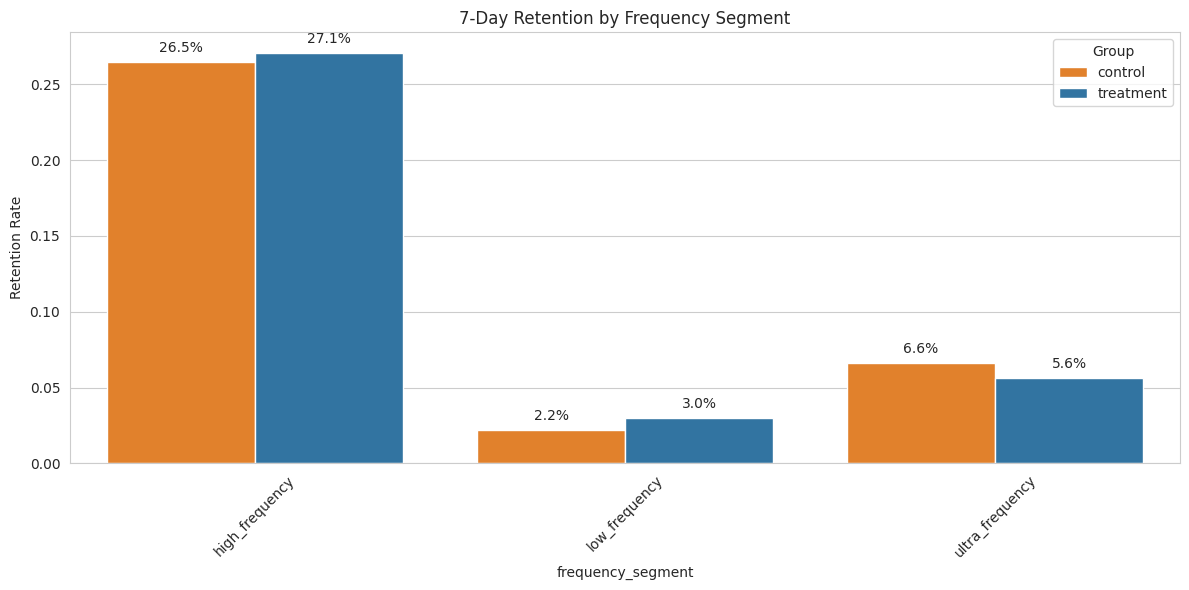

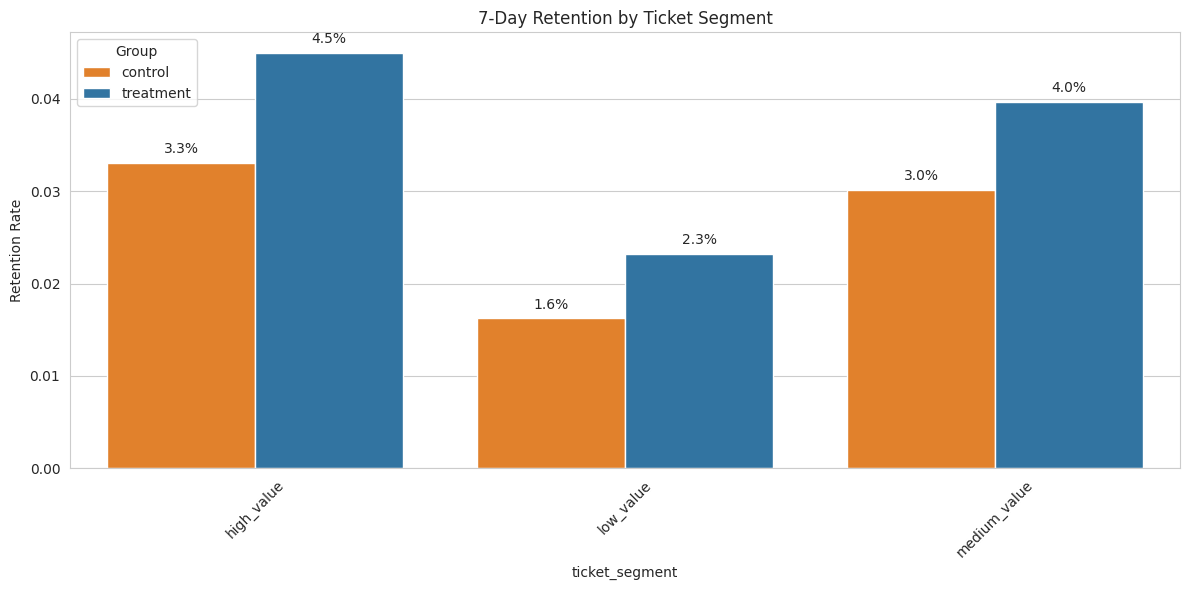

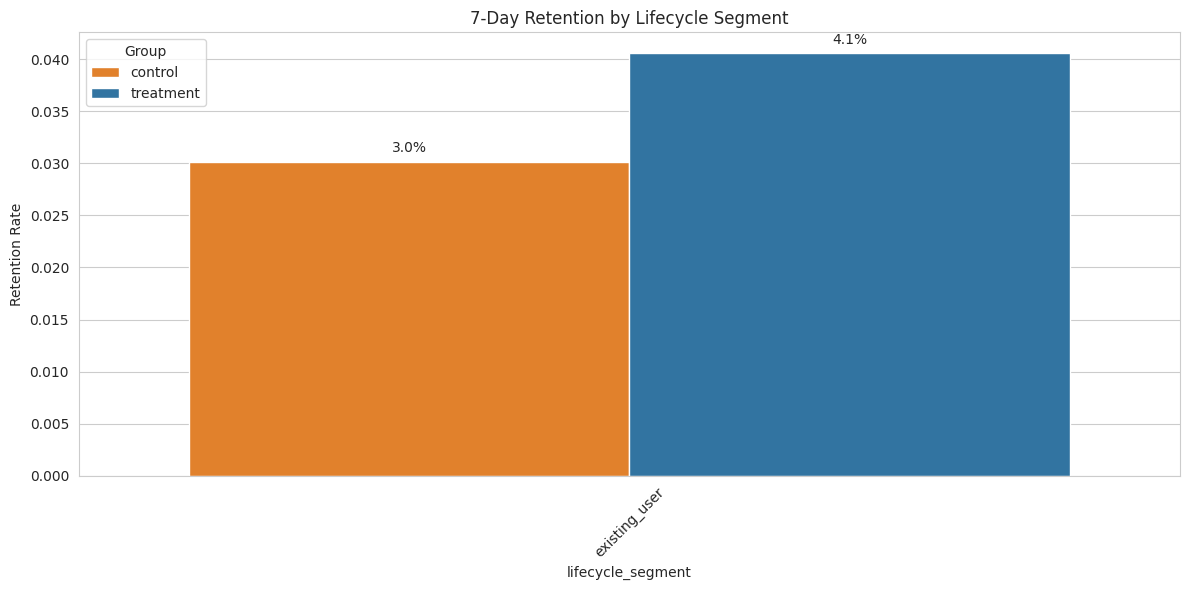

In [0]:
print("\nRetention Rate:")
plot_retention(retention_results)

In [0]:
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd

def calculate_retention_with_significance(df, campaign_start_date, retention_days=7):
    """
    Calcular a taxa de retenção por segmento e z-test.
    """

    window_spec = Window.partitionBy("user_id").orderBy("order_created_at")
    
    orders_with_sequence = df.withColumn(
        "order_rank", F.row_number().over(window_spec)
    ).withColumn(
        "next_order_date", F.lead("order_created_at").over(window_spec)
    ).withColumn(
        "days_to_next_order", F.datediff("next_order_date", "order_created_at")
    )

    first_orders = orders_with_sequence.filter(
        (F.col("order_rank") == 1) &
        (F.col("order_created_at") >= campaign_start_date)
    ).select(
        "user_id", "order_created_at",
        "frequency_segment", "ticket_segment", "lifecycle_segment", "group"
    )

    retained_users = orders_with_sequence.filter(
        (F.col("order_rank") == 2) &
        (F.col("days_to_next_order") >= retention_days)
    ).select("user_id").distinct().withColumn("is_retained", F.lit(True))

    
    def retention_with_pval(segment_col):
        summary_df = first_orders.join(
            retained_users, on="user_id", how="left"
        ).groupBy("group", segment_col).agg(
            F.count("user_id").alias("total_users"),
            F.sum(F.when(F.col("is_retained"), 1).otherwise(0)).alias("retained_users")
        ).withColumn(
            "retention_rate",
            F.col("retained_users") / F.col("total_users")
        )

        # Z-Test
        pdf = summary_df.toPandas()
        pval_results = []

        for segment in pdf[segment_col].unique():
            subset = pdf[pdf[segment_col] == segment]
            if len(subset) == 2:  
                counts = subset["retained_users"].values
                totals = subset["total_users"].values
                stat, pval = proportions_ztest(count=counts, nobs=totals)
                for i in range(2):
                    pval_results.append({
                        segment_col: segment,
                        "group": subset.iloc[i]["group"],
                        "retention_rate": subset.iloc[i]["retention_rate"],
                        "retained_users": subset.iloc[i]["retained_users"],
                        "total_users": subset.iloc[i]["total_users"],
                        "p_value": pval
                    })

        return pd.DataFrame(pval_results)

    return {
        "frequency_retention": retention_with_pval("frequency_segment"),
        "ticket_retention": retention_with_pval("ticket_segment"),
        "lifecycle_retention": retention_with_pval("lifecycle_segment")
    }


In [0]:
results = calculate_retention_with_significance(segmented_df, campaign_start_date)

print(">> Frequency Segmentation")
display(pd.DataFrame(results["frequency_retention"]))

print(">> AOV Segmentation")
display(pd.DataFrame(results["ticket_retention"]))

print(">> Lifecycle Segmentation")
display(pd.DataFrame(results["lifecycle_retention"]))

>> Frequency Segmentation


frequency_segment,group,retention_rate,retained_users,total_users,p_value
ultra_frequency,control,0.06626506024096386,22,332,0.5650084067963852
ultra_frequency,treatment,0.05630630630630631,25,444,0.5650084067963852
low_frequency,control,0.021970456229029586,2521,114745,2.1662006189898984E-34
low_frequency,treatment,0.029923709939820884,3789,126622,2.1662006189898984E-34
high_frequency,treatment,0.2707867102771561,1573,5809,0.5178709164164759
high_frequency,control,0.2648634855830569,1038,3919,0.5178709164164759


>> AOV Segmentation


ticket_segment,group,retention_rate,retained_users,total_users,p_value
medium_value,control,0.03013882763110915,1435,47613,2.490016326408844E-16
medium_value,treatment,0.0396502111439142,2122,53518,2.490016326408844E-16
low_value,control,0.01622002820874471,207,12762,4.706684530765505E-5
low_value,treatment,0.0231900862381332,320,13799,4.706684530765505E-5
high_value,treatment,0.04492205375392782,2945,65558,8.176067671992464E-27
high_value,control,0.03307688371061565,1939,58621,8.176067671992464E-27


>> Lifecycle Segmentation


lifecycle_segment,group,retention_rate,retained_users,total_users,p_value
existing_user,treatment,0.040541862652869236,5387,132875,2.5738102771871702E-45
existing_user,control,0.03009344851927796,3581,118996,2.5738102771871702E-45


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_retention_with_significance(df, segment_col):
    """
    Plotar a taxa de retenção com p-valor. """
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    ax = sns.barplot(
        x=segment_col,
        y="retention_rate",
        hue="group",
        data=df,
        palette={"treatment": "#1f77b4", "control": "#ff7f0e"}
    )

    plt.title(f"Retention Rate by {segment_col.replace('_', ' ').title()}")
    plt.ylabel("Retention Rate")
    plt.xticks(rotation=45)
    plt.legend(title="Group")

    for p in ax.patches:
        height = p.get_height()
        label = f"{height:.1%}" if height is not None else ""
        ax.annotate(label,
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

    segments = df[segment_col].unique()
    pvals = df.groupby(segment_col)["p_value"].first().to_dict()
    
    text_lines = [f"{s}: p = {pvals[s]:.4f}{' *' if pvals[s] < 0.05 else ''}" for s in segments if s in pvals]

    plt.gcf().text(1.01, 0.5, "\n".join(text_lines), fontsize=10, va='center')

    plt.tight_layout()
    plt.show()


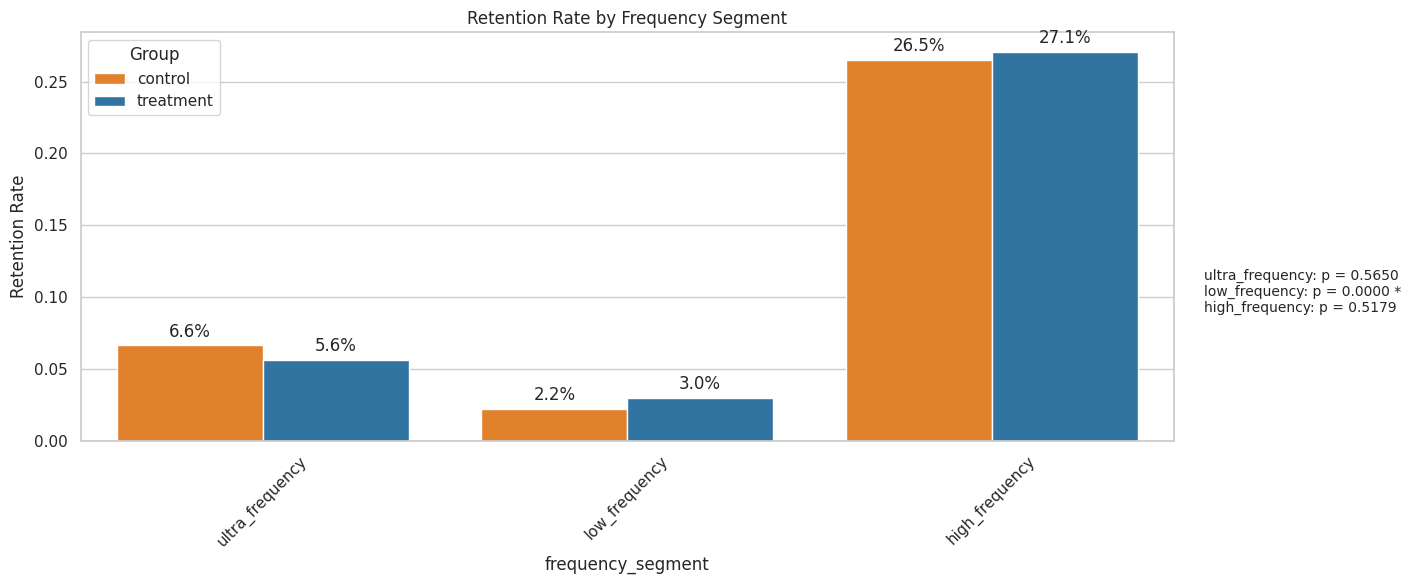

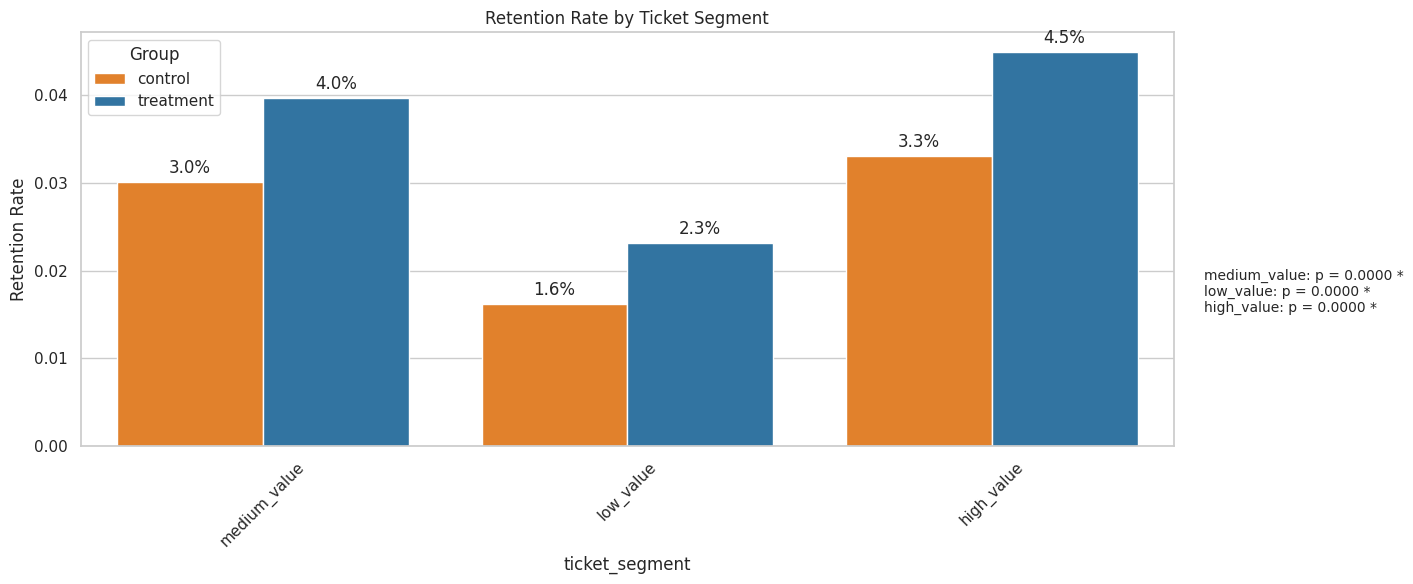

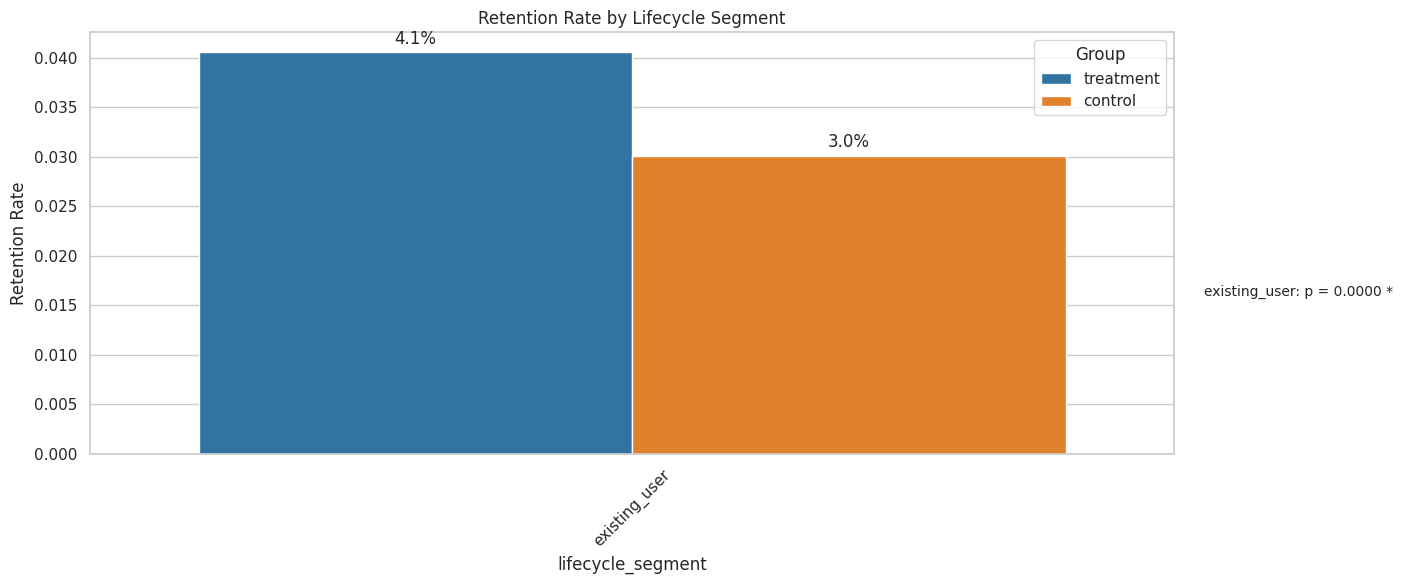

In [0]:
plot_retention_with_significance(results["frequency_retention"], "frequency_segment")
plot_retention_with_significance(results["ticket_retention"], "ticket_segment")
plot_retention_with_significance(results["lifecycle_retention"], "lifecycle_segment")

In [0]:
## Calculate retention rate during the month. 

from pyspark.sql import functions as F
from pyspark.sql.window import Window

def calculate_daily_retention(df, campaign_start_date, retention_days=7):
    """
    Calcula a taxa de retenção por dia para cada grupo (controle e tratamento).
    """
    window_spec = Window.partitionBy("user_id").orderBy("order_created_at")

    orders_with_sequence = df.withColumn(
        "order_rank", F.row_number().over(window_spec)
    ).withColumn(
        "next_order_date", F.lead("order_created_at").over(window_spec)
    ).withColumn(
        "days_to_next_order", F.datediff("next_order_date", "order_created_at")
    ).withColumn(
        "order_day", F.to_date("order_created_at")
    )

    first_orders = orders_with_sequence.filter(
        (F.col("order_rank") == 1) & (F.col("order_created_at") >= campaign_start_date)
    ).select("user_id", "group", "order_day")

    retained_users = orders_with_sequence.filter(
        (F.col("order_rank") == 2) & (F.col("days_to_next_order") >= retention_days)
    ).select("user_id").distinct().withColumn("is_retained", F.lit(True))

    retention_df = first_orders.join(retained_users, "user_id", "left").groupBy(
        "order_day", "group"
    ).agg(
        F.count("user_id").alias("total_users"),
        F.sum(F.when(F.col("is_retained"), 1).otherwise(0)).alias("retained_users")
    ).withColumn(
        "retention_rate",
        F.when(F.col("total_users") > 0, F.col("retained_users") / F.col("total_users"))
    ).withColumnRenamed("order_day", "date").orderBy("date", "group")

    return retention_df

In [0]:
retention_daily_df = calculate_daily_retention(segmented_df, campaign_start_date, retention_days=7)

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_retention_over_time(retention_by_day_df):
    pdf = retention_by_day_df.toPandas()
    pivot_df = pdf.pivot(index='date', columns='group', values='retention_rate')

    plt.figure(figsize=(12, 6))
    for group in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[group], marker='o', label=group)

    plt.title("Taxa de Retenção por Dia - Controle vs Tratamento")
    plt.xlabel("Data")
    plt.ylabel("Taxa de Retenção")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Grupo")
    plt.tight_layout()
    plt.show()

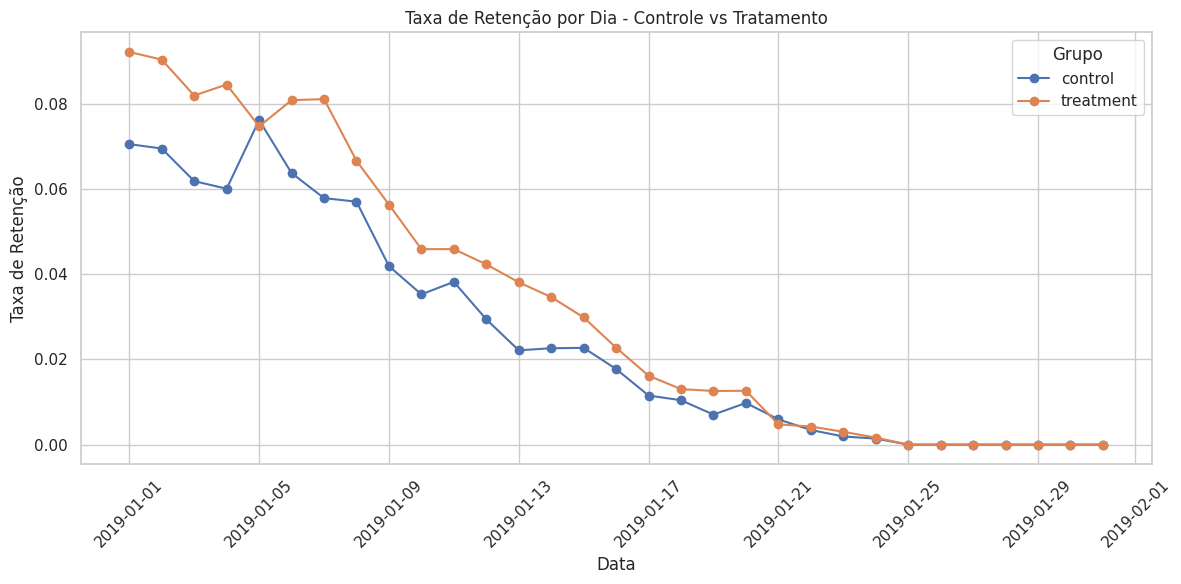

In [0]:
plot_retention_over_time(retention_daily_df)
